In [1]:
import sys
sys.path.insert(1, '../model')
import model

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter
import optuna
optuna.logging.disable_default_handler()
import pandas as pd
pd.plotting.register_matplotlib_converters()
import seaborn as sns
from scipy.integrate import solve_ivp

In [3]:
raw = pd.read_csv("../data/covid_19_data.csv")

In [4]:
#load population dict
population_df = pd.read_csv("../data/locations_population.csv")
population_country = population_df[population_df['Country.Region'] == "Czechia"].iloc[0]['Population']
population_country = int(population_country)
print(population_country) 

10650000


In [5]:
raw

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
14806,14807,04/13/2020,Wyoming,US,2020-04-13 23:15:42,275.0,1.0,0.0
14807,14808,04/13/2020,Xinjiang,Mainland China,2020-04-13 23:15:42,76.0,3.0,73.0
14808,14809,04/13/2020,Yukon,Canada,2020-04-13 23:15:42,8.0,0.0,0.0
14809,14810,04/13/2020,Yunnan,Mainland China,2020-04-13 23:15:42,184.0,2.0,174.0


In [6]:
data_cols = ["Infected", "Deaths", "Recovered"]
data_cols_all = ["Confirmed", "Infected", "Deaths", "Recovered"]
df = raw.rename({"ObservationDate": "Date", "Province/State": "Province"}, axis=1)
df["Date"] = pd.to_datetime(df["Date"])
df["Country"] = df["Country/Region"]
df.loc[df["Country"] == "Diamond Princess", ["Country", "Province"]] = ["Others", "Diamond Princess"]
df["Infected"] = df["Confirmed"] - df["Deaths"] - df["Recovered"]
df[data_cols_all] = df[data_cols_all].astype(np.int64)
ncov_df_ungrouped = df.loc[:, ["Date", "Country", "Province", *data_cols_all]]
ncov_df_ungrouped.tail()

,Date,Country,Province,Confirmed,Infected,Deaths,Recovered
14806,2020-04-13,US,Wyoming,275,274,1,0
14807,2020-04-13,Mainland China,Xinjiang,76,0,3,73
14808,2020-04-13,Canada,Yukon,8,8,0,0
14809,2020-04-13,Mainland China,Yunnan,184,8,2,174
14810,2020-04-13,Mainland China,Zhejiang,1267,27,1,1239


In [7]:
df_germany = ncov_df_ungrouped.loc[ncov_df_ungrouped["Country"] == "Czech Republic", :].groupby("Date").sum()
df_germany['Country'] = 'Czech Republic'
df_germany['Province'] = None
df_germany.tail()

,Confirmed,Infected,Deaths,Recovered,Country,Province
Date,,,,,,
2020-04-09,5569,5156,112,301,Czech Republic,None
2020-04-10,5732,5267,119,346,Czech Republic,None
2020-04-11,5831,5291,129,411,Czech Republic,None
2020-04-12,5991,5389,138,464,Czech Republic,None
2020-04-13,6059,5397,143,519,Czech Republic,None


In [8]:
df_test = pd.read_csv("../data/full-list-total-tests-for-covid-19.csv")
df_test.rename({"Cumulative total tests": "TotalTests"}, axis=1,inplace=True)
df_test["Date"] = pd.to_datetime(df_test["Date"])
df_test_germany = df_test[df_test['Entity'] == 'Czech Republic']
df_test_germany.tail()

,Entity,Code,Date,TotalTests
281,Czech Republic,CZE,2020-04-09,114854
282,Czech Republic,CZE,2020-04-10,120285
283,Czech Republic,CZE,2020-04-11,125126
284,Czech Republic,CZE,2020-04-12,128359
285,Czech Republic,CZE,2020-04-13,131542


In [9]:
result = pd.merge(df_germany,
                 df_test_germany[['Date','TotalTests']],
                 on='Date',
                 how = 'left')
from numpy import isnan
result.loc[0, ('TotalTests')] = 0 if isnan(result['TotalTests'][0]) else result['TotalTests'][0]
result['TotalTests'].interpolate(method='linear',inplace=True,limit_direction='both')
result['TotalTests'] = result['TotalTests'].astype(int)
result.tail()


,Date,Confirmed,Infected,Deaths,Recovered,Country,Province,TotalTests
39,2020-04-09,5569,5156,112,301,Czech Republic,None,114854
40,2020-04-10,5732,5267,119,346,Czech Republic,None,120285
41,2020-04-11,5831,5291,129,411,Czech Republic,None,125126
42,2020-04-12,5991,5389,138,464,Czech Republic,None,128359
43,2020-04-13,6059,5397,143,519,Czech Republic,None,131542


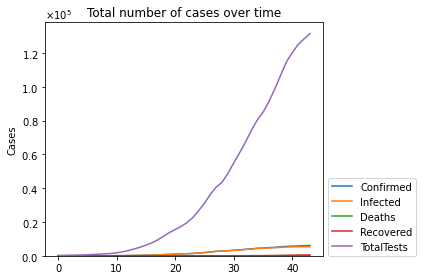

In [10]:
data_cols_all += ['TotalTests']
model.line_plot(result[data_cols_all], "Total number of cases over time")

In [11]:
ger_scenario = model.Scenario(result, name="Czech Republic", places=[("Czech Republic", None)])

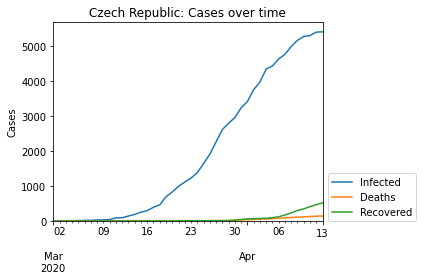

,Date,Confirmed,Infected,Deaths,Recovered
39,2020-04-09,5569,5156,112,301
40,2020-04-10,5732,5267,119,346
41,2020-04-11,5831,5291,129,411
42,2020-04-12,5991,5389,138,464
43,2020-04-13,6059,5397,143,519


In [12]:
ger_scenario.show_record().tail()

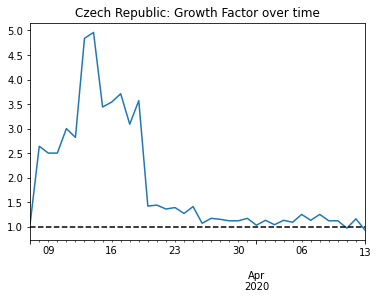

,Date,Group,GF > 1 [straight days],GF < 1 [straight days]
Czech Republic,2020-04-13,Crossroad,0,1


In [13]:
ger_scenario.growth_factor()

In [14]:
result.loc[result['Date'] == '2020-04-13']

,Date,Confirmed,Infected,Deaths,Recovered,Country,Province,TotalTests
43,2020-04-13,6059,5397,143,519,Czech Republic,None,131542


In [15]:
ger_scenario.set_phase(
    start_dates=["09Mar2020","30Mar2020","10Apr2020"],
    population=population_country
)

,start_date,end_date,population
1st,09Mar2020,29Mar2020,10650000
2nd,30Mar2020,09Apr2020,10650000
3rd,10Apr2020,-,10650000


In [16]:
ger_scenario.estimate(model.SIR)

Hyperparameter estimation of 1st phase.
	Estimator was created.
		100 trials finished in 0 min 7 sec.
	Successfully estimated.
Hyperparameter estimation of 2nd phase.
	Estimator was created.
		100 trials finished in 0 min 6 sec.
		100 trials finished in 0 min 7 sec.
		100 trials finished in 0 min 7 sec.
		100 trials finished in 0 min 8 sec.
		100 trials finished in 0 min 8 sec.
		100 trials finished in 0 min 9 sec.
		100 trials finished in 0 min 9 sec.
	Successfully estimated.
Hyperparameter estimation of 3rd phase.
	Estimator was created.
		100 trials finished in 0 min 6 sec.
	Successfully estimated.
Total: 1 min 13 sec.


In [17]:
ger_scenario.show_parameters()

,start_date,end_date,population,tau,rho,sigma,Rt,score,1/beta [day],1/gamma [day]
1st,09Mar2020,29Mar2020,10650000,1337,0.237118,0.001313,180.57,0.390667,3,707
2nd,30Mar2020,09Apr2020,10650000,1337,0.066632,0.007001,9.52,0.085220,13,132
3rd,10Apr2020,-,10650000,1337,0.020730,0.012321,1.68,0.006820,44,75


../model/model.py:762: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



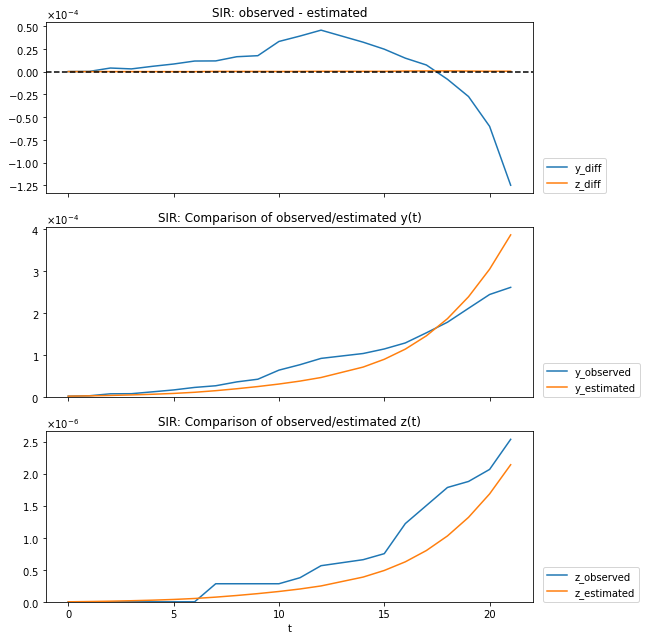

In [18]:
ger_scenario.accuracy_graph(phase_n=1)

../model/model.py:762: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



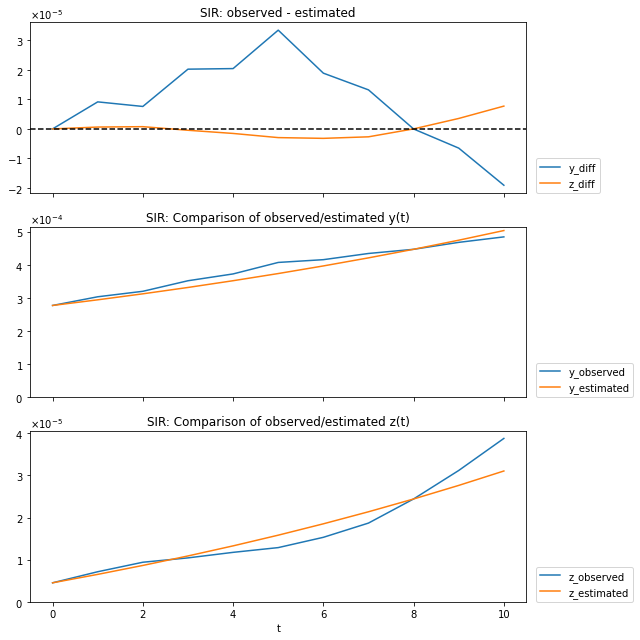

In [19]:
ger_scenario.accuracy_graph(phase_n=2)

../model/model.py:762: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



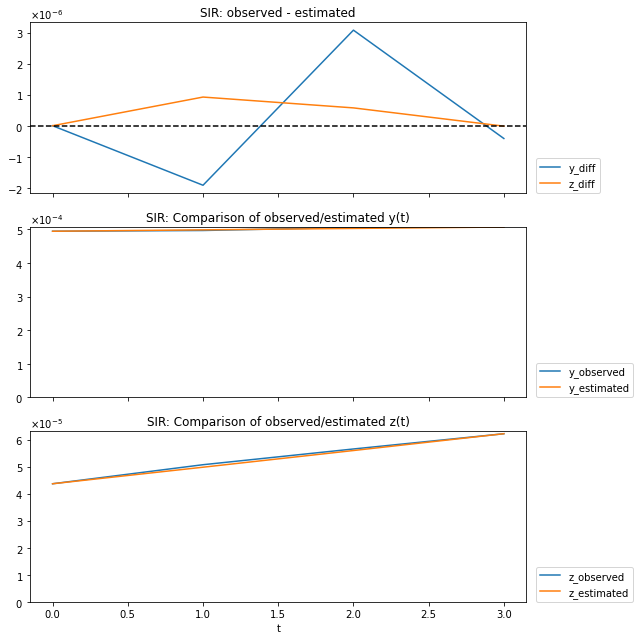

In [20]:
ger_scenario.accuracy_graph(phase_n=3)

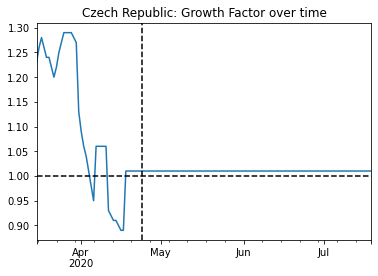

,Date,Group,GF > 1 [straight days],GF < 1 [straight days]
Czech Republic,2020-07-18 20:14:00,Outbreaking,100,0


In [21]:
ger_scenario.growth_factor(days_to_predict=100)

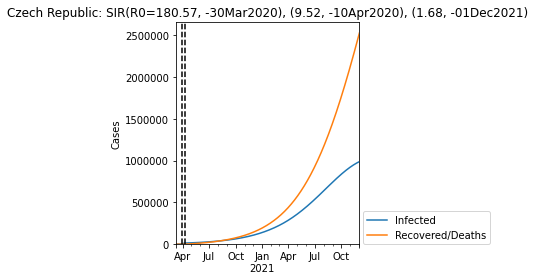

In [22]:
df = ger_scenario.predict(days=600)

In [23]:
df.loc['2020-04-09':'2020-04-12']

,Susceptible,Infected,Recovered/Deaths
Time,,,
2020-04-09 13:38:00,10636531,12713,754
2020-04-10 11:55:00,10635659,13493,846
2020-04-11 10:12:00,10635378,13607,1013
2020-04-12 08:29:00,10635096,13722,1181


SEIR MODEL

In [24]:
ger_scenario.set_phase(
    start_dates=["09Mar2020","30Mar2020","10Apr2020"],
    population=population_country
)

,start_date,end_date,population
1st,09Mar2020,29Mar2020,10650000
2nd,30Mar2020,09Apr2020,10650000
3rd,10Apr2020,-,10650000


In [25]:
ger_scenario.estimate(model.SIRD)

Hyperparameter estimation of 1st phase.
	Estimator was created.
		100 trials finished in 0 min 8 sec.
		100 trials finished in 0 min 11 sec.
		100 trials finished in 0 min 12 sec.
		100 trials finished in 0 min 13 sec.
		100 trials finished in 0 min 14 sec.
		100 trials finished in 0 min 15 sec.
		100 trials finished in 0 min 19 sec.
		100 trials finished in 0 min 21 sec.
		100 trials finished in 0 min 21 sec.
		100 trials finished in 0 min 23 sec.
		100 trials finished in 0 min 25 sec.
	Estimator will be replaced because it is incapable of improvement.
	Estimator was created.
		100 trials finished in 0 min 8 sec.
		100 trials finished in 0 min 9 sec.
		100 trials finished in 0 min 12 sec.
		100 trials finished in 0 min 12 sec.
		100 trials finished in 0 min 14 sec.
		100 trials finished in 0 min 15 sec.
		100 trials finished in 0 min 16 sec.
		100 trials finished in 0 min 18 sec.
		100 trials finished in 0 min 18 sec.
		100 trials finished in 0 min 20 sec.
		100 trials finished in 0 m

In [26]:
ger_scenario.show_parameters()

,start_date,end_date,population,tau,kappa,rho,sigma,Rt,score,1/alpha2 [day],1/beta [day],1/gamma [day]
1st,09Mar2020,29Mar2020,10650000,1311,0.000194,0.232976,0.000128,723.63,0.915375,4690,3,7120
2nd,30Mar2020,09Apr2020,10650000,1311,0.002148,0.066075,0.004314,10.22,0.125565,423,13,211
3rd,10Apr2020,-,10650000,1311,0.001561,0.020743,0.010815,1.68,0.009706,583,43,84


../model/model.py:762: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



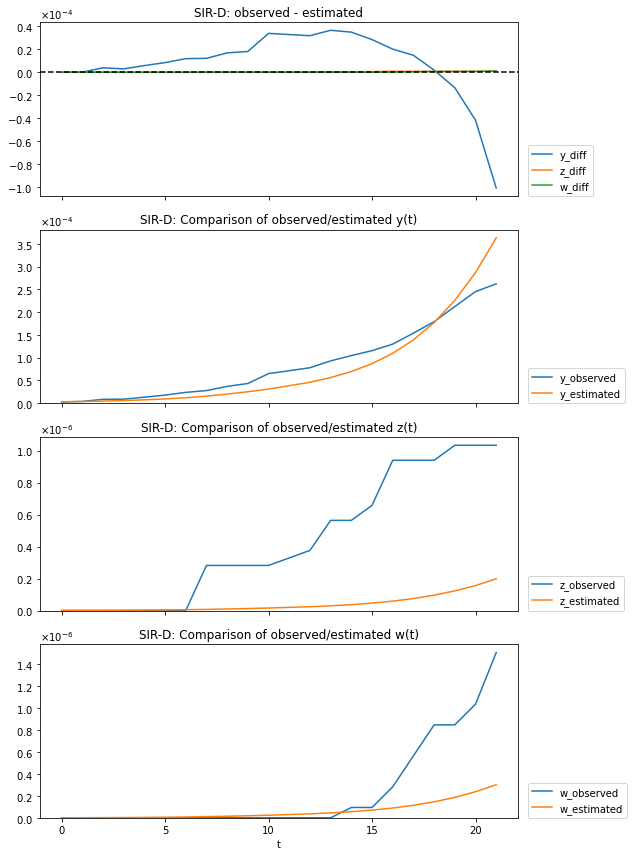

In [27]:
ger_scenario.accuracy_graph(phase_n=1)

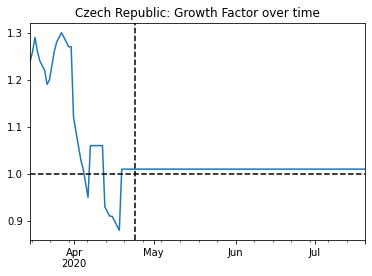

,Date,Group,GF > 1 [straight days],GF < 1 [straight days]
Czech Republic,2020-07-19 22:06:00,Outbreaking,102,0


In [28]:
ger_scenario.growth_factor(days_to_predict=100)

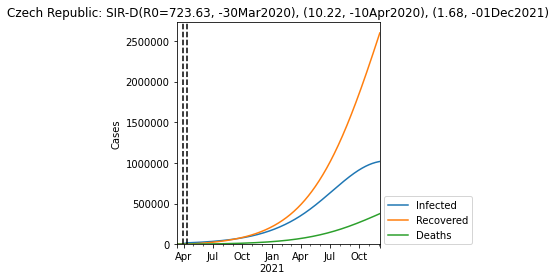

In [29]:
df = ger_scenario.predict(days=600)

In [30]:
df.loc['2020-04-09':'2020-04-12']

,Susceptible,Infected,Recovered,Deaths
Time,,,,
2020-04-09 20:45:00,10634438,14779,518,262
2020-04-10 18:36:00,10633434,15686,584,295
2020-04-11 16:27:00,10632367,16647,654,330
2020-04-12 14:18:00,10632021,16787,835,356


SEIRD MODEL

In [31]:
ger_scenario.estimate(model.SIRF)

Hyperparameter estimation of 1st phase.
	Estimator was created.
		100 trials finished in 0 min 14 sec.
	Estimator will be replaced because estimated z is non-monotonic.
	Estimator was created.
		100 trials finished in 0 min 13 sec.
	Estimator will be replaced because estimated z is non-monotonic.
	Estimator was created.
		100 trials finished in 0 min 14 sec.
	Estimator will be replaced because estimated z is non-monotonic.
	Estimator was created.
		100 trials finished in 0 min 10 sec.
\excveeded max number of tires estimated.
Hyperparameter estimation of 2nd phase.
	Estimator was created.
		100 trials finished in 0 min 8 sec.
		100 trials finished in 0 min 9 sec.
		100 trials finished in 0 min 11 sec.
	Successfully estimated.
Hyperparameter estimation of 3rd phase.
	Estimator was created.
		100 trials finished in 0 min 8 sec.
		100 trials finished in 0 min 9 sec.
		100 trials finished in 0 min 10 sec.
	Successfully estimated.
Total: 1 min 51 sec.


In [32]:
ger_scenario.show_parameters()

,start_date,end_date,population,tau,theta,kappa,rho,sigma,Rt,score,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day]
1st,09Mar2020,29Mar2020,10650000,287,0.532873,0.900328,0.028145,0.000016,0.01,2.942741,0.533,0,7,12474
2nd,30Mar2020,09Apr2020,10650000,287,0.033426,0.000105,0.010254,0.001435,6.43,0.229655,0.033,1892,19,138
3rd,10Apr2020,-,10650000,287,0.082300,0.000002,0.003836,0.002090,1.68,0.012019,0.082,99638,51,95


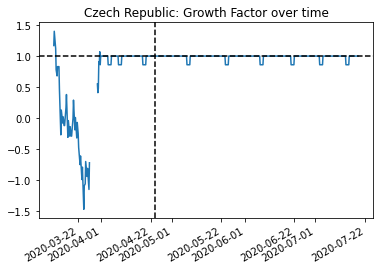

,Date,Group,GF > 1 [straight days],GF < 1 [straight days]
Czech Republic,2020-07-19 03:21:00,Crossroad,0,0


In [33]:
ger_scenario.growth_factor(days_to_predict=100)

In [34]:
df.loc['2020-04-09':'2020-04-12']

,Susceptible,Infected,Recovered,Deaths
Time,,,,
2020-04-09 20:45:00,10634438,14779,518,262
2020-04-10 18:36:00,10633434,15686,584,295
2020-04-11 16:27:00,10632367,16647,654,330
2020-04-12 14:18:00,10632021,16787,835,356


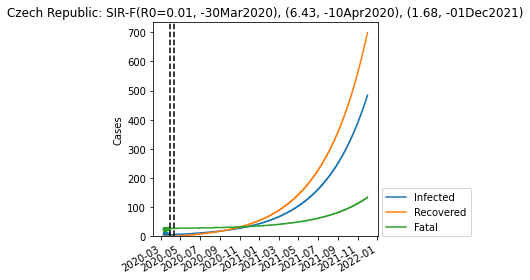

In [35]:
df = ger_scenario.predict(days=600)

SEWIRF

In [36]:
ger_scenario.estimate(model.SEWIRF)

Hyperparameter estimation of 1st phase.
	Estimator was created.
		100 trials finished in 0 min 10 sec.
		100 trials finished in 0 min 11 sec.
		100 trials finished in 0 min 13 sec.
		100 trials finished in 0 min 15 sec.
	Estimator will be replaced because estimated w is non-monotonic.
	Estimator was created.
		100 trials finished in 0 min 11 sec.
	Estimator will be replaced because estimated w is non-monotonic.
	Estimator was created.
		100 trials finished in 0 min 10 sec.
	Estimator will be replaced because estimated w is non-monotonic.
	Estimator was created.
		100 trials finished in 0 min 17 sec.
\excveeded max number of tires estimated.
Hyperparameter estimation of 2nd phase.
	Estimator was created.
		100 trials finished in 0 min 10 sec.
		100 trials finished in 0 min 11 sec.
		100 trials finished in 0 min 10 sec.
		100 trials finished in 0 min 12 sec.
		100 trials finished in 0 min 13 sec.
		100 trials finished in 0 min 14 sec.
		100 trials finished in 0 min 15 sec.
		100 trials f

In [37]:

ger_scenario.show_parameters()

,start_date,end_date,population,tau,theta,kappa,rho1,rho2,rho3,sigma,Rt,score,alpha1 [-],1/alpha2 [day],1/beta1 [day],1/beta2 [day],1/beta3 [day],1/gamma [day]
1st,09Mar2020,29Mar2020,10650000,1380,0.657634,0.005573,0.073332,0.900141,0.078925,0.000041,4.47,2.224896,0.658,171,13,1,12,23267
2nd,30Mar2020,09Apr2020,10650000,1380,0.017330,0.001314,0.200604,0.242605,0.451675,0.005208,30.22,0.157217,0.017,729,4,3,2,184
3rd,10Apr2020,-,10650000,1380,0.140858,0.001141,0.476164,0.157413,0.115772,0.010512,35.11,0.041633,0.141,839,2,6,8,91


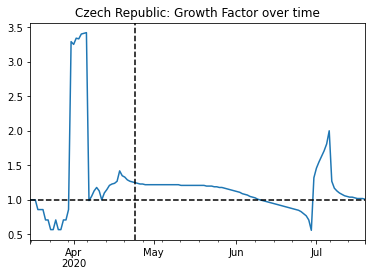

,Date,Group,GF > 1 [straight days],GF < 1 [straight days]
Czech Republic,2020-07-19 06:00:00,Outbreaking,21,0


In [38]:
ger_scenario.growth_factor(days_to_predict=100)

In [39]:
df.loc['2020-04-09':'2020-04-12']

,Susceptible,Infected,Recovered,Fatal,Confirmed
Time,,,,,
2020-04-09 02:12:00,10649965,6,0,27,33
2020-04-09 06:59:00,10649965,6,0,27,33
2020-04-09 11:46:00,10649965,6,0,27,33
2020-04-09 16:33:00,10649965,6,0,27,33
2020-04-09 21:20:00,10649965,6,0,27,33
2020-04-10 02:07:00,10649965,6,0,27,33
2020-04-10 06:54:00,10649965,6,0,27,33
2020-04-10 11:41:00,10649965,6,0,27,33
2020-04-10 16:28:00,10649965,6,0,27,33


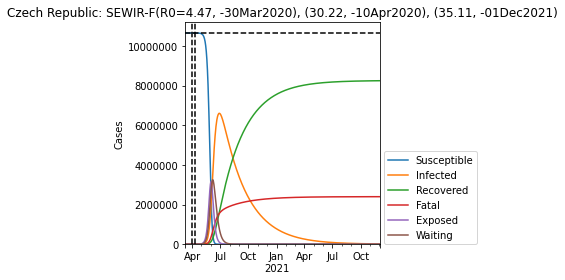

In [40]:
df = ger_scenario.predict(days=600)

PREDICTING IN PHASES

TRYING TO INCLUDE TESTS